# Homework 3 Fisherface

## Instructions
Answer the questions and upload your answers to courseville. Answers can be
in Thai or English. Answers can be either typed or handwritten and scanned.
the assignment is divided into several small tasks. Each task is weighted equally
(marked with **T**). For this assignment, each task is awarded 0.4 points. There
are also optional tasks (marked with **OT**) counts for 0.3 points each

## Hello Soft Clustering (GMM)
Recall from HW1 we did K-means clustering. Fitting a GMM on a set of
points can be considered as another method to do clustering but now with soft
assignments. <br>
&emsp; Consider the same set of points we used in HW1

|  x |  y |
|:--:|:--:|
|  1 |  2 |
|  3 |  3 |
|  2 |  2 |
|  8 |  8 |
|  6 |  6 |
|  7 |  7 |
| -3 | -3 |
| -2 | -4 |
| -7 | -7 |

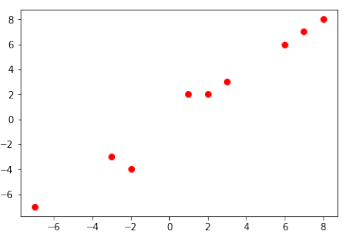

&emsp; In class, we showed that we could fit a GMM on 1-dimensional data by using
Expectation Maximization (EM). The algorithm for doing EM on N-dimensional
GMM is very similar. The exact algorithm is as follows: <br>

&emsp; **Initialization**: Initialize the mixture weights, $\phi = \{m_j\}$, where $j$ is the mixture number, means of each Gaussian, $\vec{\mu_j}$ (now a vector of N dimensions),
and covariance matrices of each Gaussian, $\Sigma_j$. <br>

&emsp; **Expectation**: Find the soft assignments for each data point $w_{n,j}$ where n corresponds to the sample index.
$$ w_{n,j} = \frac{p(x_n;\vec{\mu_j},\Sigma_j)m_j}{\Sigma_jp(x_n;\vec{\mu_j},\Sigma_j)m_j}$$
&emsp; $w_{n,j}$ means the probability that data point n comes from Gaussian number
$j$. <br>

&emsp; **Maximization**: Update the model parameters, $\phi, \vec{\mu_j}, \Sigma_j$.
$$m_j = \frac{1}{N}\Sigma_nw_{n,j}$$
$$\vec{\mu_j} = \frac{\Sigma_nw_{n,j}\vec{x_n}}{\Sigma_nw_{n,j}}$$
$$\Sigma_j = \frac{\Sigma_nw_{n,j}(\vec{x_n}-\vec{\mu_j})(\vec{x_n}-\vec{\mu_j})^T}{\Sigma_nw_{n,j}}$$
&emsp; The above equation is used for full covariance matrices. For our small toy example, we will use diagonal covariance matrices, which can be acquired by
setting the off-diagonal values to zero. In other words, $\Sigma_{(i,j)} = 0$, for $i \ne j$.

&emsp; **T1.** Using 3 mixtures, initialize your Gaussian with means (3,3), (2,2), and (-3,-3), and standard Covariance, **I**, the identity matrix. Use equal mixture weights as the initial weights. Repeat three iterations of EM. Write down $w_{n,j} , m_j , \vec{\mu_j} , \Sigma_j$ for each EM iteration. (You may do the calculations by hand
or write code to do so)

In [119]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

In [120]:
data_points = np.array([( 1, 2),
                        ( 3, 3),
                        ( 2, 2),
                        ( 8, 8),
                        ( 6, 6),
                        ( 7, 7),
                        (-3,-3),
                        (-2,-4),
                        (-7,-7)])

In [121]:
# For T1      
""" 𝜙 """
phis = np.array([1/3, 1/3, 1/3])

""" 𝜇 """
means = np.array([(3,   3),
                  (2,   2), 
                  (-3, -3)])

""" Σ """
covs = np.array([np.identity(2), np.identity(2), np.identity(2)]) 

In [122]:
class GMM():
    def __init__(self):
        self.k = None
        self.phis = None
        self.means = None
        self.covs = None
        self.W = None
        self.data_points = None
        self.llh_history = None
    
    def initialization(self, k, phis, means, covs, data_points):
        self.k = k
        self.phis = phis
        self.means = means;
        self.covs = covs
        self.data_points = data_points
        self.llh_history = []
        self.get_llh()
        
    def expectation(self):
        W = np.zeros((self.data_points.shape[0], self.k))
        for j in range(self.k):
            W_j = multivariate_normal.pdf(self.data_points, mean=self.means[j], cov=self.covs[j]) * self.phis[j]
            W[:,j] = W_j
        W = np.array([W_n/W_n.sum() for W_n in W])
        self.W = W
    
    def maximization(self, get_diag = True):
        # phis
        new_phis = np.zeros(self.k)
        for j in range(self.k):
            new_phi_j = self.W[:,j].sum()/self.data_points.shape[0]
            new_phis[j] = new_phi_j
        new_phis = np.array(new_phis)
        #print(new_phis)
        
        # means
        new_means = np.zeros((self.k, self.data_points.shape[1]))
        for j in range(self.k):
            new_mean = self.W[:,j].reshape((self.data_points.shape[0],1)) * self.data_points
            new_mean = new_mean.transpose()
            new_means[j] = np.array([dim.sum() for dim in new_mean])/self.W[:,j].sum()
        #print(new_means)
        
        # covs
        new_covs = []
        for j in range(self.k):
            new_cov = np.zeros_like(self.covs[0])
            diff = self.data_points - self.means[j]
            for n, data in enumerate(diff):
                sub_cov = self.W[n,j]*np.matmul(data.reshape((data.shape[0], 1)), data.reshape(1, data.shape[0]))
                new_cov += sub_cov
            new_covs.append(new_cov/self.W[:,j].sum())
        new_covs = np.array(new_covs)
        if get_diag:
            new_covs = np.array([np.diag(np.diag(cov))  for cov in new_covs])  
        #print(new_covs)
        
        self.phis = new_phis
        self.means = new_means
        self.covs = new_covs
        self.get_llh()
            
    def summary(self):
        print("k :", self.k)
        print("phis :", self.phis)
        print("means :"); print(self.means)
        print("covs :"); print(self.covs)
        print("W :"); print(self.W)
        print("llh_his :"); print(self.llh_history)
    
    def get_llh(self):
        p_s = np.zeros((self.data_points.shape[0], self.k))
        for j in range(self.k):
            p_s[:,j] = multivariate_normal.pdf(self.data_points, mean=self.means[j], cov=self.covs[j])
        wp_s = p_s*self.phis
        lhs = np.array([data.sum() for data in wp_s])
        llhs = np.log(lhs)
        self.llh_history.append(llhs.sum())
            
    def plot_llh(self):
        X = range(len(self.llh_history))
        Y = self.llh_history
        plt.plot(X,Y)
        plt.show()
    
    def plot(self):
        N    = 200
        X    = np.linspace(self.data_points[:,0].min()-1, self.data_points[:,0].max()+1, N)
        Y    = np.linspace(self.data_points[:,1].min()-1, self.data_points[:,1].max()+1, N)
        X, Y = np.meshgrid(X, Y)
        pos  = np.dstack((X, Y))
        for j in range(self.k):
            rv = multivariate_normal(self.means[j], self.covs[j])
            Z = rv.pdf(pos)
            plt.contour(X, Y, Z)
        plt.scatter(self.data_points[:,0],self.data_points[:,1])
        plt.show()

In [123]:
gmm = GMM()

In [124]:
gmm.initialization(3, phis, means, covs, data_points)
gmm.summary()

k : 3
phis : [0.33333333 0.33333333 0.33333333]
means :
[[ 3  3]
 [ 2  2]
 [-3 -3]]
covs :
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
W :
None
llh_his :
[-93.17390123755948]


In [125]:
gmm.expectation() #iteration 1
print(gmm.W)

[[1.19202922e-01 8.80797076e-01 1.81545808e-09]
 [7.31058579e-01 2.68941421e-01 1.69570706e-16]
 [2.68941421e-01 7.31058579e-01 1.01529005e-11]
 [9.99983299e-01 1.67014218e-05 2.03105874e-42]
 [9.99088949e-01 9.11051194e-04 5.37528453e-32]
 [9.99876605e-01 1.23394576e-04 3.30529272e-37]
 [2.31952283e-16 1.38879439e-11 1.00000000e+00]
 [2.31952283e-16 1.38879439e-11 1.00000000e+00]
 [3.30570063e-37 5.90009054e-29 1.00000000e+00]]


In [126]:
gmm.maximization()
gmm.summary()

k : 3
phis : [0.45757242 0.20909425 0.33333333]
means :
[[ 5.78992692  5.81887265]
 [ 1.67718211  2.14523106]
 [-4.         -4.66666666]]
covs :
[[[12.31988634  0.        ]
  [ 0.         12.23304914]]

 [[ 0.62066718  0.        ]
  [ 0.          0.15261824]]

 [[ 5.66666667  0.        ]
  [ 0.          5.66666668]]]
W :
[[1.19202922e-01 8.80797076e-01 1.81545808e-09]
 [7.31058579e-01 2.68941421e-01 1.69570706e-16]
 [2.68941421e-01 7.31058579e-01 1.01529005e-11]
 [9.99983299e-01 1.67014218e-05 2.03105874e-42]
 [9.99088949e-01 9.11051194e-04 5.37528453e-32]
 [9.99876605e-01 1.23394576e-04 3.30529272e-37]
 [2.31952283e-16 1.38879439e-11 1.00000000e+00]
 [2.31952283e-16 1.38879439e-11 1.00000000e+00]
 [3.30570063e-37 5.90009054e-29 1.00000000e+00]]
llh_his :
[-93.17390123755948, -42.10307442013231]


In [127]:
gmm.expectation() #iteration 2
print(gmm.W)

[[1.81294622e-002 9.81582998e-001 2.87540002e-004]
 [5.64494061e-001 4.35380622e-001 1.25316584e-004]
 [1.92846943e-002 9.80633501e-001 8.18047710e-005]
 [1.00000000e+000 4.70826685e-062 5.03915978e-012]
 [9.99999990e-001 3.82283898e-027 1.01750382e-008]
 [1.00000000e+000 7.32691444e-043 2.49006494e-010]
 [1.59795152e-003 7.69753019e-045 9.98402048e-001]
 [1.55069753e-003 5.89612118e-058 9.98449302e-001]
 [3.59091243e-006 1.89005654e-144 9.99996409e-001]]


In [128]:
gmm.maximization()
gmm.summary()

k : 3
phis : [0.40056227 0.26639968 0.33303805]
means :
[[ 6.30842698  6.31259558]
 [ 1.77218759  2.1815904 ]
 [-4.00062813 -4.66675525]]
covs :
[[[3.24482139 0.        ]
  [0.         3.18737779]]

 [[0.54812076 0.        ]
  [0.         0.14993733]]

 [[4.67362081 0.        ]
  [0.         2.89766742]]]
W :
[[1.81294622e-002 9.81582998e-001 2.87540002e-004]
 [5.64494061e-001 4.35380622e-001 1.25316584e-004]
 [1.92846943e-002 9.80633501e-001 8.18047710e-005]
 [1.00000000e+000 4.70826685e-062 5.03915978e-012]
 [9.99999990e-001 3.82283898e-027 1.01750382e-008]
 [1.00000000e+000 7.32691444e-043 2.49006494e-010]
 [1.59795152e-003 7.69753019e-045 9.98402048e-001]
 [1.55069753e-003 5.89612118e-058 9.98449302e-001]
 [3.59091243e-006 1.89005654e-144 9.99996409e-001]]
llh_his :
[-93.17390123755948, -42.10307442013231, -38.543439206723406]


In [129]:
gmm.expectation() #iteration 3
print(gmm.W)

[[1.81240251e-004 9.99812736e-001 6.02360765e-006]
 [1.40770128e-001 8.59229229e-001 6.42663215e-007]
 [4.85324724e-004 9.99513546e-001 1.12958651e-006]
 [1.00000000e+000 7.30562640e-064 3.40271752e-019]
 [1.00000000e+000 4.88274872e-028 5.02342563e-014]
 [1.00000000e+000 3.05867029e-044 1.26696752e-016]
 [4.85980138e-012 2.29092578e-047 1.00000000e+000]
 [3.11260608e-012 1.78986020e-060 1.00000000e+000]
 [1.09172834e-023 1.82739807e-151 1.00000000e+000]]


In [130]:
gmm.maximization()
gmm.summary()

k : 3
phis : [0.34904852 0.31761728 0.3333342 ]
means :
[[ 6.81963839  6.81969608]
 [ 1.95082009  2.30058161]
 [-3.9999862  -4.66664913]]
covs :
[[[1.58836939 0.        ]
  [0.         1.58356938]]

 [[0.67983404 0.        ]
  [0.         0.22439122]]

 [[4.6667292  0.        ]
  [0.         2.88899996]]]
W :
[[1.81240251e-004 9.99812736e-001 6.02360765e-006]
 [1.40770128e-001 8.59229229e-001 6.42663215e-007]
 [4.85324724e-004 9.99513546e-001 1.12958651e-006]
 [1.00000000e+000 7.30562640e-064 3.40271752e-019]
 [1.00000000e+000 4.88274872e-028 5.02342563e-014]
 [1.00000000e+000 3.05867029e-044 1.26696752e-016]
 [4.85980138e-012 2.29092578e-047 1.00000000e+000]
 [3.11260608e-012 1.78986020e-060 1.00000000e+000]
 [1.09172834e-023 1.82739807e-151 1.00000000e+000]]
llh_his :
[-93.17390123755948, -42.10307442013231, -38.543439206723406, -36.19157145495558]


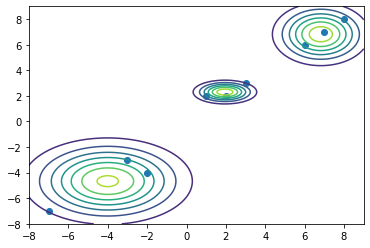

In [131]:
gmm.plot()

&emsp;**T2.** Plot the log likelihood of the model given the data after each EM step. In other words, plot $log \; \Pi_np(\vec{x_n}|\phi,\vec{\mu},\Sigma)$. Does it goes up every iteration just
as we learned in class?


In [132]:
gmm.llh_history

[-93.17390123755948,
 -42.10307442013231,
 -38.543439206723406,
 -36.19157145495558]

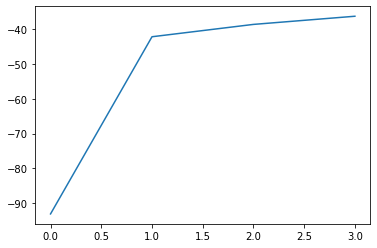

In [133]:
gmm.plot_llh()

&emsp; **T3.** Using 2 mixtures, initialize your Gaussian with means (3,3) and (-3,-3), and standard Covariance, **I**, the identity matrix. Use equal mixture weights as the initial weights. Repeat three iterations of EM. Write down $w_{n,j}, m_j, \vec{\mu_j}, \Sigma_j$
for each EM iteration.

In [134]:
# For T3      
""" 𝜙 """
phis = np.array([1/2, 1/2])

""" 𝜇 """
means = np.array([(3,   3), 
                  (-3, -3)])

""" Σ """
covs = np.array([np.identity(2), np.identity(2)]) 

In [135]:
gmm = GMM()

In [136]:
gmm.initialization(2, phis, means, covs, data_points)
gmm.summary()

k : 2
phis : [0.5 0.5]
means :
[[ 3  3]
 [-3 -3]]
covs :
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
W :
None
llh_his :
[-93.27921820745587]


In [137]:
gmm.expectation()
print(gmm.W)

[[9.99999985e-01 1.52299795e-08]
 [1.00000000e+00 2.31952283e-16]
 [1.00000000e+00 3.77513454e-11]
 [1.00000000e+00 2.03109266e-42]
 [1.00000000e+00 5.38018616e-32]
 [1.00000000e+00 3.30570063e-37]
 [2.31952283e-16 1.00000000e+00]
 [2.31952283e-16 1.00000000e+00]
 [3.30570063e-37 1.00000000e+00]]


In [138]:
gmm.maximization()
gmm.summary()

k : 2
phis : [0.66666666 0.33333334]
means :
[[ 4.50000001  4.66666667]
 [-3.99999997 -4.66666663]]
covs :
[[[9.16666668 0.        ]
  [0.         8.66666669]]

 [[5.66666672 0.        ]
  [0.         5.66666677]]]
W :
[[9.99999985e-01 1.52299795e-08]
 [1.00000000e+00 2.31952283e-16]
 [1.00000000e+00 3.77513454e-11]
 [1.00000000e+00 2.03109266e-42]
 [1.00000000e+00 5.38018616e-32]
 [1.00000000e+00 3.30570063e-37]
 [2.31952283e-16 1.00000000e+00]
 [2.31952283e-16 1.00000000e+00]
 [3.30570063e-37 1.00000000e+00]]
llh_his :
[-93.27921820745587, -46.88887010186105]


In [139]:
gmm.expectation()
print(gmm.W)

[[9.94979696e-01 5.02030393e-03]
 [9.99922646e-01 7.73541258e-05]
 [9.98623856e-01 1.37614400e-03]
 [1.00000000e+00 6.27933891e-12]
 [9.99999994e-01 6.33185482e-09]
 [1.00000000e+00 2.12626993e-10]
 [2.77132409e-03 9.97228676e-01]
 [2.45908782e-03 9.97540912e-01]
 [1.30217751e-06 9.99998698e-01]]


In [140]:
gmm.maximization()
gmm.summary()

k : 2
phis : [0.66652866 0.33347134]
means :
[[ 4.49739004  4.66243446]
 [-3.9912655  -4.65434481]]
covs :
[[[6.94971903 0.        ]
  [0.         5.94046426]]

 [[4.72011919 0.        ]
  [0.         2.98099996]]]
W :
[[9.94979696e-01 5.02030393e-03]
 [9.99922646e-01 7.73541258e-05]
 [9.98623856e-01 1.37614400e-03]
 [1.00000000e+00 6.27933891e-12]
 [9.99999994e-01 6.33185482e-09]
 [1.00000000e+00 2.12626993e-10]
 [2.77132409e-03 9.97228676e-01]
 [2.45908782e-03 9.97540912e-01]
 [1.30217751e-06 9.99998698e-01]]
llh_his :
[-93.27921820745587, -46.88887010186105, -46.29297528619903]


In [141]:
gmm.expectation()
print(gmm.W)

[[9.99840572e-01 1.59427561e-04]
 [9.99999613e-01 3.86910944e-07]
 [9.99967636e-01 3.23639718e-05]
 [1.00000000e+00 2.77855078e-18]
 [1.00000000e+00 1.61298139e-13]
 [1.00000000e+00 7.52961598e-16]
 [2.56424026e-04 9.99743576e-01]
 [1.65413279e-04 9.99834587e-01]
 [6.05550189e-09 9.99999994e-01]]


In [142]:
gmm.maximization()
gmm.summary()

k : 2
phis : [0.66669218 0.33330782]
means :
[[ 4.49960686  4.66618544]
 [-3.99986439 -4.66641867]]
covs :
[[[6.9196161  0.        ]
  [0.         5.89303254]]

 [[4.66851519 0.        ]
  [0.         2.89184297]]]
W :
[[9.99840572e-01 1.59427561e-04]
 [9.99999613e-01 3.86910944e-07]
 [9.99967636e-01 3.23639718e-05]
 [1.00000000e+00 2.77855078e-18]
 [1.00000000e+00 1.61298139e-13]
 [1.00000000e+00 7.52961598e-16]
 [2.56424026e-04 9.99743576e-01]
 [1.65413279e-04 9.99834587e-01]
 [6.05550189e-09 9.99999994e-01]]
llh_his :
[-93.27921820745587, -46.88887010186105, -46.29297528619903, -46.29195955411724]


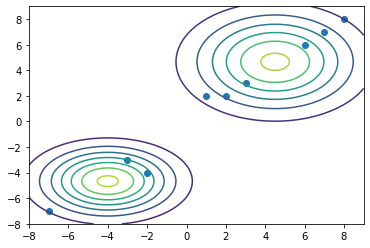

In [143]:
gmm.plot()

&emsp; **T4.** Plot the log likelihood of the model given the data after each EM step. Compare the log likelihood between using two mixtures and three mixtures. Which one has the better likelihood?


In [144]:
gmm.llh_history

[-93.27921820745587,
 -46.88887010186105,
 -46.29297528619903,
 -46.29195955411724]

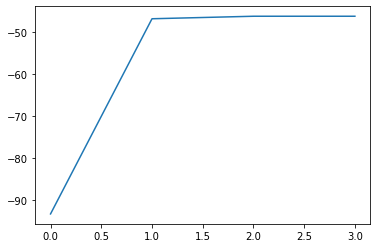

In [145]:
gmm.plot_llh()

## The face database
For the rest of the homework we will work on face verification (Given a face, say whether it is person A or not). Face verification is quite related to face recognition (Given a face, say who it is). Face verification is a binary classification task, while face recognition is a multi-class problem. <br>
&emsp; Download the file **facedata.mat** from github. You can load the data by

In [146]:
import scipy.io
x = scipy.io.loadmat("facedata.mat")

&emsp; data is a dictionary with key value pairs. The data you want to use can be
accessed by using ‘facedata’ as the key.

(40, 10)
[[48 46 50 ... 50 54 53]
 [47 47 48 ... 37 46 50]
 [46 48 43 ... 33 41 51]
 ...
 [49 49 50 ... 45 46 47]
 [48 48 49 ... 45 46 46]
 [51 48 50 ... 45 45 46]]
(56, 46)


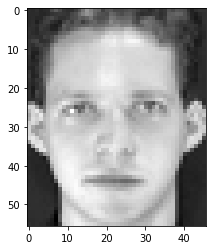

In [147]:
# face data is a 2-dimensional array with size 40x10
print(x['facedata'].shape)

# Each data is indexed by i and j
# where i is the person index
# j is the index of the pose
# In other words, there are 40 people in the database.
# There are 10 images per person.
print(x['facedata'][0,0])

# Each image is a 56 by 46 image
print(x['facedata'][0,0].shape)

# You can see the image by using the imshow in matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(x['facedata'][0,0],cmap="gray")
plt.show()

### &emsp; Working with images
&emsp; Each pixel in an image is usually represented by a 8-bit unsigned integer
(values from 0 to 255). In order to easily work on images, we usually convert
them to floats or doubles using the following command.


In [148]:
from skimage import img_as_float
xf = {}
xf[0,0] = img_as_float(x['facedata'][0,0])
print(xf[0,0])

[[0.18823529 0.18039216 0.19607843 ... 0.19607843 0.21176471 0.20784314]
 [0.18431373 0.18431373 0.18823529 ... 0.14509804 0.18039216 0.19607843]
 [0.18039216 0.18823529 0.16862745 ... 0.12941176 0.16078431 0.2       ]
 ...
 [0.19215686 0.19215686 0.19607843 ... 0.17647059 0.18039216 0.18431373]
 [0.18823529 0.18823529 0.19215686 ... 0.17647059 0.18039216 0.18039216]
 [0.2        0.18823529 0.19607843 ... 0.17647059 0.17647059 0.18039216]]


&emsp; **img_as_float** scales 0-255 to 0-1. You can still show the image using the same **imshow** command. <br>
&emsp; Note that the index of a 2D image starts from the upper left corner of the image. The first dimension goes downwards, while the second dimension goes
to the right (think of it as a matrix). To understand what this means, try the
following code.


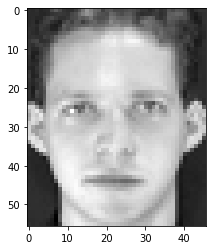

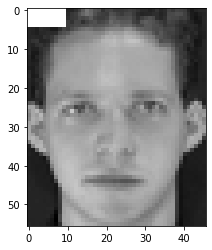

In [149]:
plt.imshow(xf[0,0],cmap="gray")
plt.show()
x_temp = xf[0,0].copy()
x_temp[0:5,0:10] = 1
# In float format, 1 is white
plt.imshow(x_temp,cmap="gray")
plt.show()

### &emsp; The similarity matrix
&emsp; Consider a set of $N$ data points, a similarity matrix $S$ is a matrix where $S_{i,j}$ is the distance between the ith and the jth data point. A similarity matrix can
be very useful for analyzing the data and its distribution. Since a similarity
matrix can also be considered as an image, you can also show it as an image to
see the pattern in the data. <br>
&emsp; But how do we define similarity? How can we quantify whether image $A$ is closer to $B$ than image $C$? One way is to treat each pixel in image as an element in a vector (you may find the function **numpy.reshape()** useful). Then, compare
the two vectors using Euclidean distance.
Euclidean distance between vector $x$ and $y$ is defined as:
$$Euclidean\_distance = \sqrt{\Sigma_d(x_d-y_d)^2}$$
&emsp; where d refers to the index of the dimension.

&emsp; **T5.** What is the Euclidean distance between **xf[0,0]** and **xf[0,1]**? What is the Euclidean distance between **xf[0,0]** and **xf[1,0]**? Does the numbers make sense? Do you think these numbers will be useful for face verification? <br>
&emsp; As we continue our exercise, we will refine our feature vectors so that the Euclidean distance between two images can be used in a face verification system. <br>
&emsp; We define the similarity matrix, $A$, as a matrix whose elements $A_{i,j}$ is the Euclidean distance between data sample $i$ from list $T$ and data sample $j$ from list $D$, where list $T$, $D$ are lists of data samples.

In [150]:
def Euclidian_distance(img_f1, img_f2, isVec=False):
    if not isVec:
        v_1 = img_f1.reshape(-1)
        v_2 = img_f2.reshape(-1)
    else:
        v_1 = img_f1
        v_2 = img_f2
    SE = (v_1 - v_2)**2
    return np.sqrt(SE.sum())

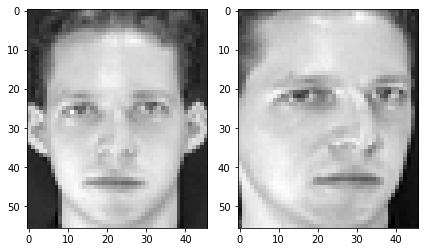

Euclidean distance: 10.037616294165492


In [151]:
xf[0,0] = img_as_float(x['facedata'][0,0])
xf[0,1] = img_as_float(x['facedata'][0,1])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(xf[0,0],cmap="gray")
ax2.imshow(xf[0,1],cmap="gray")
plt.tight_layout()
plt.show()
print("Euclidean distance:", Euclidian_distance(xf[0,0], xf[0,1]))

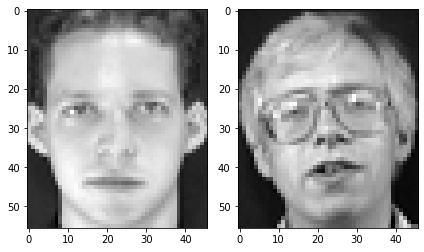

Euclidean distance: 8.173295099737281


In [152]:
xf[0,0] = img_as_float(x['facedata'][0,0])
xf[1,0] = img_as_float(x['facedata'][1,0])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(xf[0,0],cmap="gray")
ax2.imshow(xf[1,0],cmap="gray")
plt.tight_layout()
plt.show()
print("Euclidean distance:", Euclidian_distance(xf[0,0], xf[1,0]))

&emsp; The Euclidean distance xf[0,0] and xf[0,1] is 10.037616294165492. <br>
&emsp; The Euclidean distance xf[0,0] and xf[1,0] is 8.173295099737281. <br>
&emsp; Euclidean distance number does not make sense. <br>
&emsp; These numbers will be useful if we can modify the image to something that can calculate with Euclidean distance.

&emsp; **T6.** Write a function that takes in a set of feature vectors T and a set of feature vectors $D$, and then output the similarity matrix $A$. Show the matrix as an image. Use the feature vectors from the first 3 images from all 40 people
for list $T$ (in order **x[0, 0]**, **x[0, 1]**, **x[0, 2]**, **x[1, 0]**, **x[1, 1]**, ...**x[39, 2]**). Use the feature vectors from the remaining 7 images from all 40 people for list D (in order **x[0, 3]**, **x[0, 4]**, **x[0, 5]**, **x[1, 6]**, **x[0, 7]**, **x[0, 8]**, **x[0, 9]**, **x[1, 3]**, **x[1, 4]**...**x[39, 9]**). We will treat $T$ as our training images and $D$ as our testing images <br>

In [153]:
T = []
D = []
for i in range(40):
    for j in range(0, 3):
        xf[i,j] = img_as_float(x['facedata'][i,j])
        T.append(xf[i,j])
    for j in range(3,10):
        xf[i,j] = img_as_float(x['facedata'][i,j])
        D.append(xf[i,j])
T = np.array(T)
D = np.array(D)

In [154]:
A = np.zeros((T.shape[0], D.shape[0]))
for i in range(T.shape[0]):
    for j in range(D.shape[0]):
        A[i,j] = Euclidian_distance(T[i], D[j])
print(A)

[[10.36960631  9.84869463  8.99622801 ...  9.89638826  9.36151948
  10.66062617]
 [11.24987522  7.4172114   9.88066979 ... 10.9694266  10.90238961
  10.93630575]
 [10.22209276  9.41321639  9.29987742 ...  9.99689456  9.94499521
  10.41008147]
 ...
 [11.50315003 10.77719551 11.45361976 ...  5.5842077   9.25718815
   7.93519019]
 [ 9.82401314 10.09262219  9.9006693  ...  6.75074775  7.45046954
   8.90196597]
 [ 9.75449186  9.98745234 10.16210857 ...  6.51894822  7.88934623
   9.55831251]]


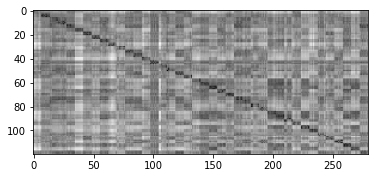

In [155]:
plt.imshow(A,cmap="gray")
plt.show()

&emsp; The picture below shows an example similarity matrix calculated by the first 5 images from the first 5 people (for both $T$ and $D$).

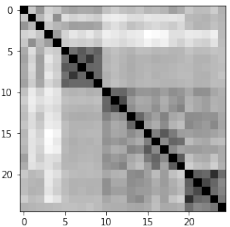

&emsp; **T7.** From the example similarity matrix above, what does the black square between [5:10,5:10] suggest about the pictures from person number 2? What do the patterns from person number 1 say about the images from person 1?

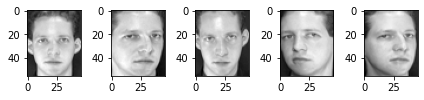

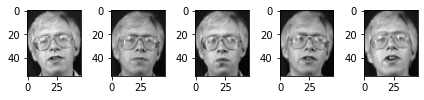

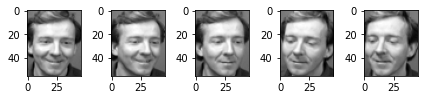

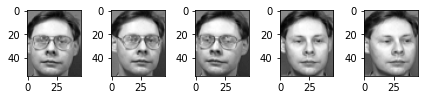

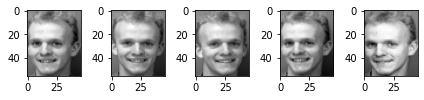

In [156]:
for i in range(5):
    fig, ax = plt.subplots(1, 5)
    for j in range(5):
        ax[j].imshow(xf[i,j],cmap="gray")
        plt.tight_layout()
plt.show()

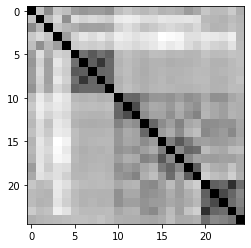

In [157]:
v_tmp = []
for i in range(5):
    for j in range(5):
        v_tmp.append(xf[i,j])
v_tmp = np.array(v_tmp)
A_tmp = np.zeros((25,25))
for i in range(25):
    for j in range(25):
        A_tmp[i,j] = Euclidian_distance(v_tmp[i], v_tmp[j])
plt.imshow(A_tmp,cmap="gray")
plt.show()

&emsp; We know that from Euclidian distance, image A is similar to image B if distance near 0 (is black color). From similarity matrix, black square between [5:10,5:10] means 5 images from person number 2 are similarly. On the other hand, 5 images from the person number are different.

### &emsp; A simple face verification system
&emsp; In our simple face verification system, given a test image, we want to test if that image comes from person A or not. We will compare the test image
against the three training images from person A we have. If the minimum
distance (between the three training images) is below a threshold, t, we say
that the test image is person A.

&emsp; **T8.** Write a function that takes in the similarity matrix created from the previous part, and a threshold $t$ as inputs. The outputs of the function are the true positive rate and the false alarm rate of the face verification task (280 Test images, tested on 40 people, a total of 11200 testing per threshold). What is the true positive rate and the false alarm rate for $t = 10$?

In [158]:
# T train , D test
# similarity matix: A[T,D]
# threshold: t
def verify(A, t):
    thresholded_matrix = A < t
    thresholded_matrix = thresholded_matrix.transpose()
    TP = 0; TN = 0; FP = 0; FN = 0
    for idx, data in enumerate(thresholded_matrix):
        for i in range(0, 120 ,3):
            output = data[i] or data[i+1] or data[i+2]
            if output and (i/3 == idx//7):
                #print("TP")
                TP += 1
            if output and (i/3 != idx//7):
                #print("FP")
                FP += 1
            if (not output) and (i/3 == idx//7):
                #print("FN")
                FN += 1
            if (not output) and (i/3 != idx//7):
                #print("TN")
                TN += 1
    TPR = TP/(TP + FN)
    FAR = FP/(TN + FP)
    return TPR,FAR

In [159]:
verify(A, 10)

(0.9964285714285714, 0.4564102564102564)

&emsp; **T9.** Plot the RoC curve for this simple verification system. What should be the minimum threshold to generate the RoC curve? What should be the maximum threshold? Your RoC should be generated from at least 1000 threshold levels equally spaced between the minimum and the maximum. (You should
write a function for this).

In [160]:
A.min()

1.7420153428787784

&emsp; Minimum threshold to generate the RoC curve sholde be 0 or 1.

In [161]:
A.max()

17.541726165424688

&emsp; Maximum threshold to generate the RoC curve sholde be 18.

In [162]:
def plot_RoC_from_A(A, min=0, max=18, num=1000, EER=False, FA=-1, plot=True):
    TPRs = []; FARs = []
    for t in np.linspace(min, max, num):
        TPR, FAR = verify(A, t)
        TPRs.append(TPR)
        FARs.append(FAR)
    if plot:
        plt.figure(figsize=(5, 5))
        plt.plot(FARs,TPRs)
        if EER:
            plt.plot([0,1],[1,0])
        if (FA < 1) and (FA > 0):
            plt.axvline(FA, color="g")
        plt.show()
    return (TPRs, FARs)

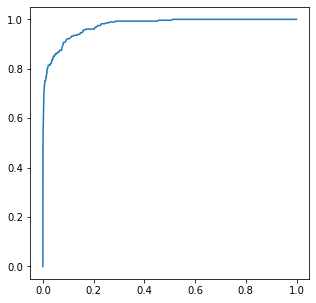

In [163]:
(TPRs, FARs) = plot_RoC_from_A(A,0,18,1000)

&emsp; **T10.** What is the EER (Equal Error Rate)? What is the recall rate at 0.1% false alarm rate? (Write this in the same function as the previous question)


&emsp; EER is a threshold that equalizes the False positive rate and False negative rate.

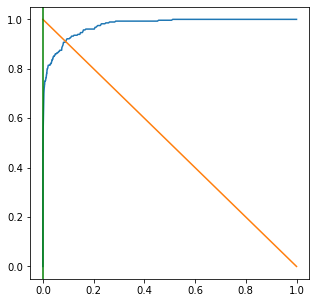

0.34285714285714286 9.157509157509158e-05


In [164]:
(TPRs, FARs) = plot_RoC_from_A(A,0,18,1000, EER=True, FA=0.1/100)
for idx, FA in enumerate(FARs):
    if np.abs(FA-0.1/100) < 1e-3:
        TP_target = TPRs[idx]
        FA_target = FARs[idx]
        break
print(TP_target, FA_target)

&emsp; At 0.1% FAR, recall rate (TPR) is 0.34285714285714286.

### &emsp; Principle Component Analysis (PCA)
&emsp; PCA is a method for dimensionality reduction that is very flexible and fits many use cases. It is unsupervised (needs no class label). The core of PCA is using eigendecomposition to decompose the data into the directions of maximum variance. <br>
&emsp; Let’s define a matrix $X$ with each column as an input sample $\vec{x_i}$ <br>
&emsp; A typical PCA starts by normalizing each feature dimension so that they
have equal range. For our case, since our input vectors are already between 0
and 1, we can skip this step. <br>
&emsp; The first step of PCA is to first remove the global mean from our data. Let $\vec{\mu_x}$ be the means of the input data along each input dimension. Let $\hat{X}$ be the matrix with the mean of the input samples removed. Be sure to use the mean
computed from just the training examples.

&emsp; **T11.** Compute the mean vector from the training images. Show the vector as an image (use **numpy.reshape()**). This is typically called the meanface (or meanvoice for speech signals). You answer should look exactly like the image shown below.
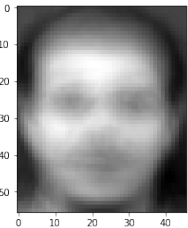
&emsp; We can then compute eigenvectors on the covariance matrix computed from
$\hat{X}$. The PCA vectors would correspond to the eigenvectors, $\vec{v}$ . In other words, <br>
$$\Sigma\vec{v} = \lambda\vec{v}$$
However, as learned in class, if we compute the covariance matrix, we would
need a lot of space to store it.

In [165]:
T.shape

(120, 56, 46)

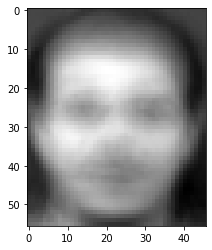

In [166]:
X = np.array([t.reshape(-1) for t in T]).transpose()
mean_x = np.array([pixels.mean() for pixels in X])
mean_img = mean_x.reshape((56, 46))
plt.imshow(mean_img,cmap="gray")
plt.show()

&emsp; **T12.** What is the size of the covariance matrix? What is the rank of the covariance matrix? <br>
&emsp; The trick we learned in class is to compute the Gram Matrix $(\hat{X^T}\hat{X})$, which
is the inner product between the input matrices.


In [167]:
X_hat = (X.T - mean_x).T
cov = np.matmul(X_hat, X_hat.T)
print(cov.shape)
gram = np.matmul(X_hat.T, X_hat)
print(gram.shape)
rank = np.linalg.matrix_rank(gram)
print(rank)

(2576, 2576)
(120, 120)
119


&emsp; The size of the covariance matrix is 2576*2576. <br>
&emsp; The rank is 119.

&emsp; **T13.** What is the size of the Gram matrix? What is the rank of Gram
matrix? If we compute the eigenvalues from the Gram matrix, how many nonzero eigenvalues do we expect to get?

In [168]:
gram.shape

(120, 120)

&emsp; The size of the Gram matrix is 120*120. <br>
&emsp; There are 119 ranks in Gram matrix. <br>
&emsp; There are 119 nonzero eigenvalues in Gram matrix.

&emsp; **T14.** Is the Gram matrix also symmetric? Why? <br>

In [169]:
def is_symmetric(X):
    return (X==X.T).sum() == X.shape[0]*X.shape[1]

In [170]:
is_symmetric(gram)

True

&emsp; The Gram matrix is symmetric because Gram matrix $G$ is equal $G^T$.

&emsp; Using the gram matrix, we instead solve for the eigenvector, $\vec{v'}$ <br>
$$\hat{X^T}\hat{X}\vec{v'} = \lambda\vec{v'}$$
&emsp; where the desired eigenvector (eigenvector of the covariance matrix) can be computed from $\vec{v'}$ (eigenvector of the gram matrix) using the following relationship <br>
$$\vec{v} = \hat{X}\vec{v'}$$
&emsp; In order to compute the eigenvectors and eigenvalues, we can use the function
**numpy.linalg.eigh** which can be used on symmetric matrices. For symmetric matrices, the eigenvectors and eigenvalues will always be real. In contrast, if the matrix is not symmetric, we have to use the function **numpy.linalg.eig** which will output complex numbers.

&emsp; **T15.** Compute the eigenvectors and eigenvalues of the Gram matrix, $\vec{v'}$
and $\lambda$. Sort the eigenvalues and eigenvectors in descending order so that the first eigenvalue is the highest, and the first eigenvector corresponds to the best direction. How many non-zero eigenvalues are there? If you see a very small value, it is just numerical error and should be treated as zero.

In [171]:
ei_vals_gram, ei_vecs_gram = np.linalg.eigh(gram)
ei_vals_gram = ei_vals_gram[::-1]
ei_vecs_gram = ei_vecs_gram[:,::-1]

In [172]:
ei_vecs_gram.shape

(120, 120)

In [173]:
(ei_vals_gram > 0).sum()

119

In [174]:
ei_vecs_gram

array([[ 0.07820028, -0.08144841,  0.16838572, ..., -0.03284951,
         0.01171851, -0.09128709],
       [ 0.15633363, -0.06891888,  0.00607299, ..., -0.00712131,
         0.00347436, -0.09128709],
       [ 0.14076739, -0.04460943,  0.08922514, ...,  0.03802993,
         0.01301747, -0.09128709],
       ...,
       [ 0.03542524, -0.08254825, -0.13635891, ..., -0.01356318,
         0.00197116, -0.09128709],
       [ 0.04815903, -0.11167625, -0.06627051, ..., -0.03108812,
        -0.02639082, -0.09128709],
       [ 0.04395375, -0.12893456, -0.07990511, ...,  0.02085834,
         0.01616482, -0.09128709]])

&emsp; There are 119 non-zero eigenvalues.

&emsp; **T16.** Plot the eigenvalues. Observe how fast the eigenvalues decrease. In class, we learned that the eigenvalues is the size of the variance for each eigenvector direction. If I want to keep 95% of the variance in the data, how many eigenvectors should I use?

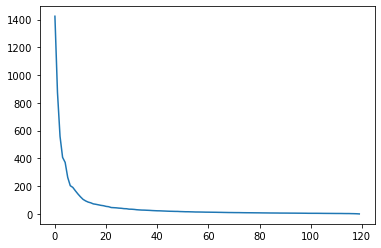

In [175]:
plt.plot(range(ei_vals_gram.shape[0]), ei_vals_gram)
plt.show()

In [176]:
for k in range(ei_vals_gram.shape[0]):
    per = ei_vals_gram[:k+1].sum()/ei_vals_gram.sum()
    pos = k+1
    if per > 0.95:
        break
print(pos, per)

64 0.9514558774601827


&emsp; We use 63 eigenvectors if we want to keep 95% of variance in the data.

&emsp; **T17.** Compute $\vec{v}$. Don’t forget to renormalize so that the norm of each vector is 1 (you can use **numpy.linalg.norm**). Show the first 10 eigenvectors as images. Two example eigenvectors are shown below. We call these images eigenfaces (or eigenvoice for speech signals).
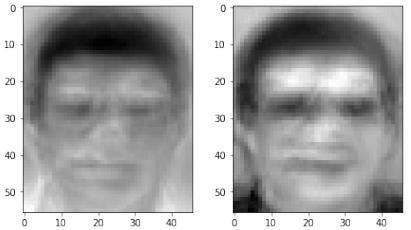

In [177]:
X_hat.shape

(2576, 120)

In [178]:
ei_vecs = np.array([np.matmul(X_hat, vec)/np.linalg.norm(np.matmul(X_hat, vec)) for vec in ei_vecs_gram.T]).T

In [179]:
ei_vecs.T.shape

(120, 2576)

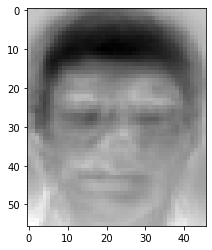

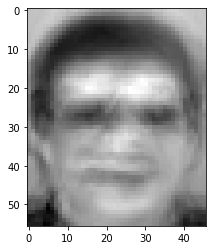

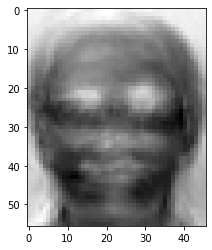

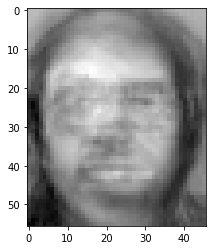

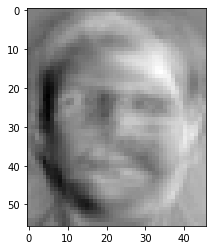

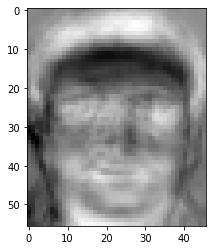

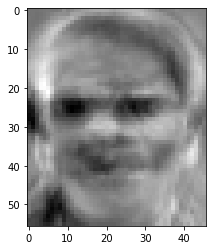

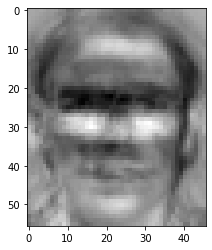

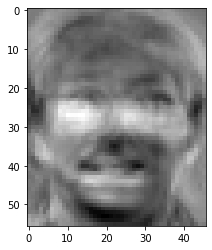

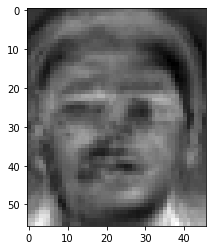

In [180]:
for vec in ei_vecs.T[:10]:
    img = vec.reshape(56, 46)
    plt.imshow(1-img,cmap="gray")
    plt.show()

&emsp; **T18.** From the image, what do you think the first eigenvector captures? What about the second eigenvector? Look at the original images, do you think biggest variance are capture in these two eigenvectors?

&emsp; From the first eigenvector, it captures human hair area. <br>
&emsp; The second eigenvector captures eyes, hair and neck. <br>
&emsp; From the original images, the biggest variance are captured in these two eigenvectors.

### &emsp; PCA subspace and the face verification system
&emsp; These eigenfaces we computed serve as good directions to project our data onto in order to decrease the number of dimensions. Since we have shown in class that these eigenvectors are orthogonal (and we normalized them so that they are orthonormal), we can find the projection, $\vec{p}$, of the data onto the eigenface subspace by <br>
$$\vec{p} = V^T(\vec{x}-\vec{\mu_x})$$
where $V$ is a matrix whose columns are the eigenvectors, $\vec{v}$. The projection values, $\vec{p}$ , will serve as our new input features.

&emsp; **T19.** Find the projection values of all images. Keep the first k = 10 projection values. Repeat the simple face verification system we did earlier using these projected values. What is the EER and the recall rate at 0.1% FAR?

In [181]:
V = ei_vecs
k = 10
print("V.T    shape:", V.T.shape)
print("D      shape:", D.shape)
D_vecs = np.array([x.reshape(-1) for x in D])
print("D_vecs shape:", D_vecs.shape)
print("T      shape:", T.shape)
T_vecs = np.array([data.reshape(-1) for data in T])
print("T_vecs shape:", T_vecs.shape)

V.T    shape: (120, 2576)
D      shape: (280, 56, 46)
D_vecs shape: (280, 2576)
T      shape: (120, 56, 46)
T_vecs shape: (120, 2576)


In [182]:
D_P_k10 = np.array([np.matmul(V.T[:k], x.reshape(x.shape[0], 1) - mean_x.reshape(mean_x.shape[0], 1)) for x in D_vecs])
D_P_k10 = np.array([col_vec.reshape(-1) for col_vec in D_P_k10])
print(D_P_k10.shape)
T_P_k10 = np.array([np.matmul(V.T[:k], x.reshape(x.shape[0], 1) - mean_x.reshape(mean_x.shape[0], 1)) for x in T_vecs])
T_P_k10 = np.array([col_vec.reshape(-1) for col_vec in T_P_k10])
print(T_P_k10.shape)

(280, 10)
(120, 10)


In [183]:
A_P_k10 = np.zeros((T_P_k10.shape[0], D_P_k10.shape[0]))
for i in range(T_P_k10.shape[0]):
    for j in range(D_P_k10.shape[0]):
        A_P_k10[i,j] = Euclidian_distance(T_P_k10[i], D_P_k10[j], isVec=True)
print(A_P_k10)

[[7.22125794 6.96215974 5.44867025 ... 7.82315762 6.59140858 8.80941491]
 [7.20795589 5.52059958 4.7094784  ... 8.60664234 7.97256662 8.71148207]
 [6.71962453 6.03575774 5.19594851 ... 7.7624584  6.71723841 7.92069238]
 ...
 [7.47270404 7.76469557 7.39518281 ... 1.34926929 5.08577523 4.70747106]
 [6.14624408 6.98868431 6.20361041 ... 3.98854631 3.26837646 6.37922045]
 [6.31032647 7.14805727 6.780653   ... 3.84145244 4.43360861 6.88969656]]


In [184]:
verify(A_P_k10, 10)

(1.0, 0.8434065934065934)

In [185]:
print(A_P_k10.min(), A_P_k10.max())

0.2803389280466323 15.82038362801947


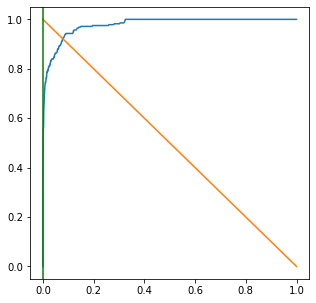

0.33214285714285713 9.157509157509158e-05


In [186]:
(TPRs, FARs) = plot_RoC_from_A(A_P_k10,0,18,1000, EER=True, FA=0.1/100)
for idx, FA in enumerate(FARs):
    if np.abs(FA-0.1/100) < 1e-3:
        TP_target = TPRs[idx]
        FA_target = FARs[idx]
        break
print(TP_target, FA_target)

&emsp; **T20.** What is the k that gives the best EER? Try k = 5, 6, 7, 8, 9, 10, 11, 12, 13, 14.

In [187]:
D_P_ks = {}
T_P_ks = {}
A_P_ks = {}
for k in range(5, 15):
    D_P_k = np.array([np.matmul(V.T[:k], x.reshape(x.shape[0], 1) - mean_x.reshape(mean_x.shape[0], 1)) for x in D_vecs])
    D_P_k = np.array([col_vec.reshape(-1) for col_vec in D_P_k])
    D_P_ks[k] = D_P_k
    T_P_k = np.array([np.matmul(V.T[:k], x.reshape(x.shape[0], 1) - mean_x.reshape(mean_x.shape[0], 1)) for x in T_vecs])
    T_P_k = np.array([col_vec.reshape(-1) for col_vec in T_P_k])
    T_P_ks[k] = T_P_k
    A_P_k = np.zeros((T_P_k10.shape[0], D_P_k10.shape[0]))
    for i in range(T_P_k.shape[0]):
        for j in range(D_P_k.shape[0]):
            A_P_k[i,j] = Euclidian_distance(T_P_k[i], D_P_k[j], isVec=True)
    A_P_ks[k] = A_P_k

In [188]:
TPR_ks = {}
FAR_ks = {}
EER_ks = {}
for k in range(5, 15):
    print("=======================================================")
    print(f"k: {k}")
    print(f"TPR, FAR:", verify(A_P_ks[k], 10))
    print(f"min, max:", A_P_ks[k].min(), A_P_ks[k].max())
    (TPRs, FARs) = plot_RoC_from_A(A_P_ks[k], 0, 18, 1000, EER=True, FA=0.1, plot=False)
    for idx, FA in enumerate(FARs):
        if (TPRs[idx] + FA - 1 < 1e-3) and (TPRs[idx] + FA - 1 > -1e-3):
            TP_target = TPRs[idx]
            FA_target = FARs[idx]
            break
    print(f"EER TPR, FAR:", TP_target, FA_target)
    EER_ks[k] = (TP_target, FA_target)

k: 5
TPR, FAR: (1.0, 0.9072344322344322)
min, max: 0.18946561871746986 15.66513650200062
EER TPR, FAR: 0.8928571428571429 0.10622710622710622
k: 6
TPR, FAR: (1.0, 0.8941391941391942)
min, max: 0.2030471736124507 15.736685198553845
EER TPR, FAR: 0.8928571428571429 0.10622710622710622
k: 7
TPR, FAR: (1.0, 0.8793040293040293)
min, max: 0.2146965076331923 15.759483537803794
EER TPR, FAR: 0.9071428571428571 0.09258241758241759
k: 8
TPR, FAR: (1.0, 0.8670329670329671)
min, max: 0.26301823538736874 15.761623825782095
EER TPR, FAR: 0.9142857142857143 0.0848901098901099
k: 9
TPR, FAR: (1.0, 0.8556776556776556)
min, max: 0.2798449793645433 15.761648850012602
EER TPR, FAR: 0.9142857142857143 0.0848901098901099
k: 10
TPR, FAR: (1.0, 0.8434065934065934)
min, max: 0.2803389280466323 15.82038362801947
EER TPR, FAR: 0.9214285714285714 0.07884615384615384
k: 11
TPR, FAR: (1.0, 0.8323260073260074)
min, max: 0.28063526278379514 15.84865231976834
EER TPR, FAR: 0.9214285714285714 0.07847985347985348
k: 12


In [189]:
for k in range(5, 15):
    print(f"k:{k:2d} , EER = {EER_ks[k]}")

k: 5 , EER = (0.8928571428571429, 0.10622710622710622)
k: 6 , EER = (0.8928571428571429, 0.10622710622710622)
k: 7 , EER = (0.9071428571428571, 0.09258241758241759)
k: 8 , EER = (0.9142857142857143, 0.0848901098901099)
k: 9 , EER = (0.9142857142857143, 0.0848901098901099)
k:10 , EER = (0.9214285714285714, 0.07884615384615384)
k:11 , EER = (0.9214285714285714, 0.07847985347985348)
k:12 , EER = (0.9142857142857143, 0.08553113553113553)
k:13 , EER = (0.9142857142857143, 0.08553113553113553)
k:14 , EER = (0.9178571428571428, 0.0815934065934066)


&emsp; k = 11 that gives the best EER. <br>
&emsp; TPR = 0.9214285714285714. <br>
&emsp; FAR = 0.07847985347985348.

### &emsp; (Optional) PCA reconstruction
&emsp; One of the usage for PCA is compression. Using the project values, we can reconstruct the original image. This can be done by <br>
$$\vec{x'} = \vec{\mu_x} + \Sigma_kp_k\vec{v_k}$$
$$\vec{x'} = \vec{\mu_x} + V\vec{p}$$
&emsp; where $\vec{x'}$ is the reconstructed image. <br>
&emsp; We can compute the error from such reconstruction by computing the Mean
Square Error (MSE) <br>
$$MSE = \sum_{i=1}^N \frac{1}{N}(x_i- x'_i)^2$$
&emsp; where $N$ is the dimension of the original input.

&emsp; **OT1.** Reconstruct the first image using this procedure. Use k = 10, what is the MSE?

In [190]:
k = 10
original_image_vec = T[0].reshape(-1)
projection_vec = T_P_ks[k][0]
print(projection_vec.shape)
reconstructed_image_vec = mean_x + np.matmul(V.T[:k].T, projection_vec)
print(original_image_vec.shape, reconstructed_image_vec.shape)

(10,)
(2576,) (2576,)


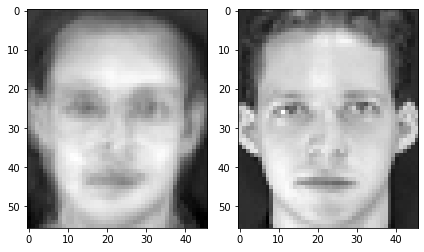

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(reconstructed_image_vec.reshape(56,46), cmap="gray")
ax2.imshow(original_image_vec.reshape(56,46), cmap="gray")
plt.tight_layout()
plt.show()

In [192]:
def MSE(vec_1, vec_2):
    return ((vec_1 - vec_2)**2/vec_1.shape[0]).sum()

In [193]:
MSE(original_image_vec, reconstructed_image_vec)

0.006148335016488307

&emsp; From reconstructed image, we get MSE is 0.006148335016488307.

&emsp; **OT2.** For k values of 1,2,3,...,10,119, show the reconstructed images. Plot the MSE values.

k: 1


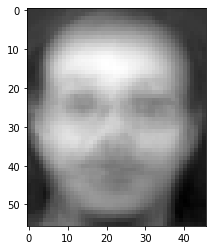

k: 2


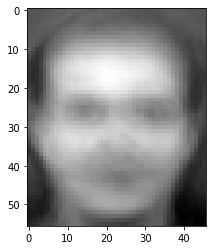

k: 3


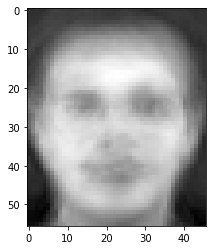

k: 4


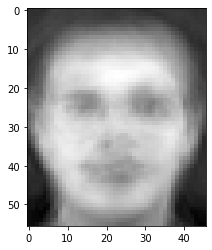

k: 5


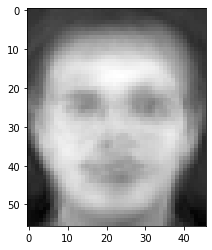

k: 6


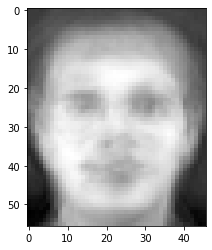

k: 7


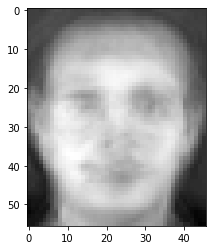

k: 8


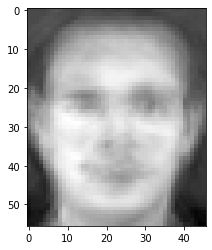

k: 9


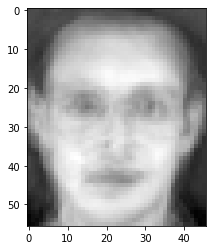

k: 10


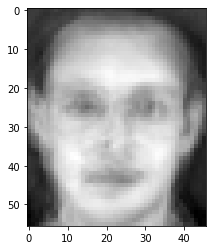

k: 11


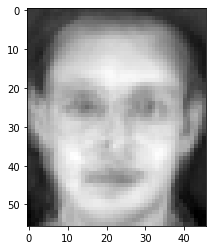

k: 12


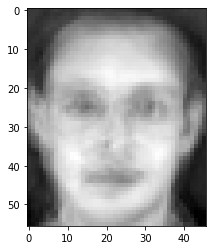

k: 13


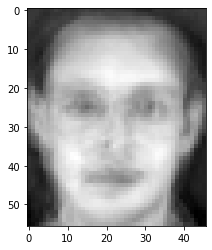

k: 14


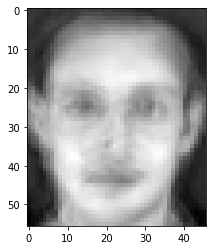

k: 15


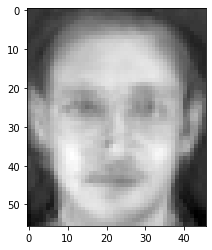

k: 16


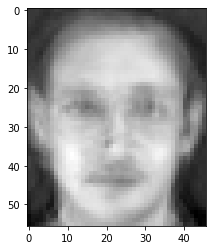

k: 17


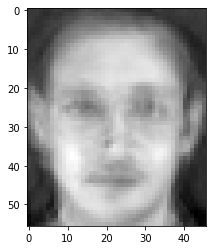

k: 18


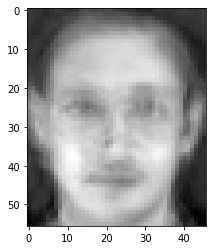

k: 19


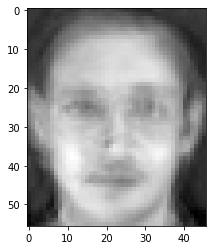

k: 20


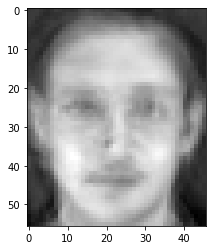

k: 21


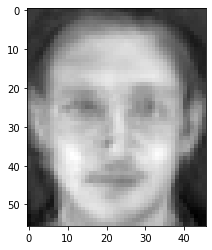

k: 22


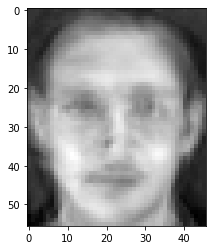

k: 23


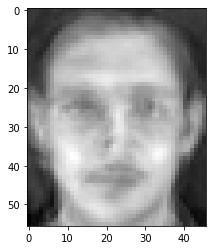

k: 24


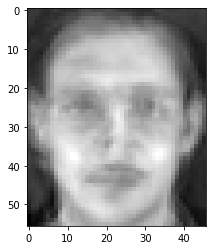

k: 25


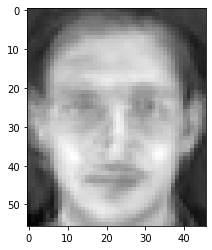

k: 26


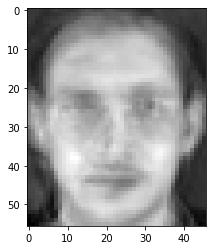

k: 27


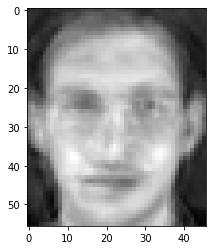

k: 28


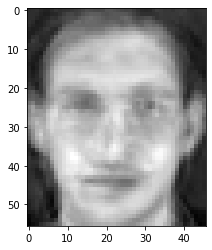

k: 29


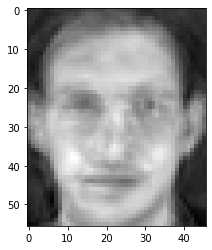

k: 30


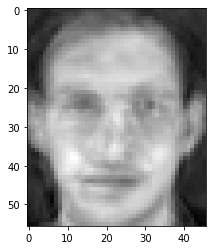

k: 31


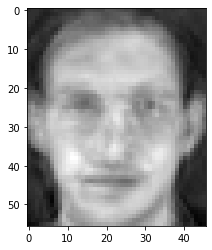

k: 32


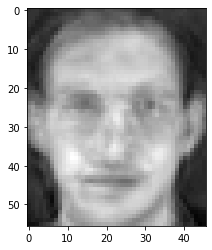

k: 33


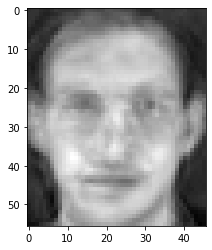

k: 34


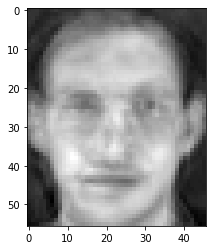

k: 35


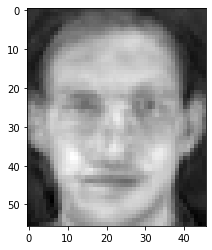

k: 36


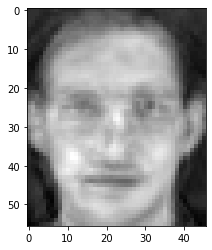

k: 37


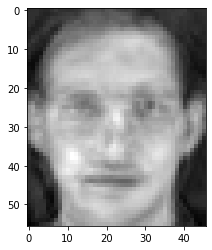

k: 38


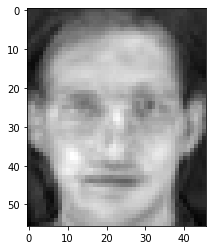

k: 39


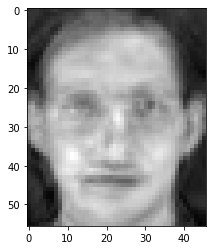

k: 40


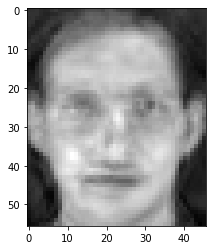

k: 41


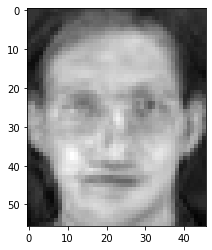

k: 42


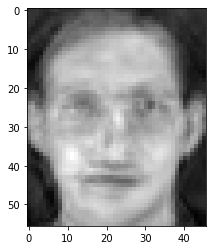

k: 43


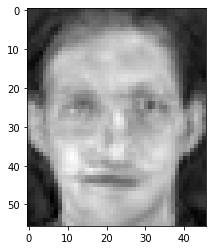

k: 44


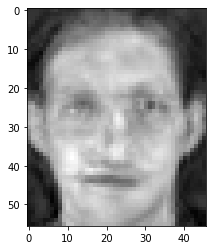

k: 45


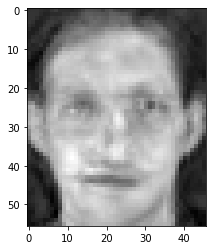

k: 46


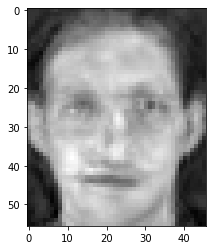

k: 47


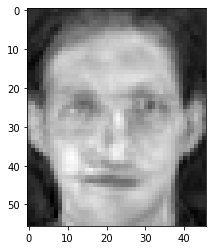

k: 48


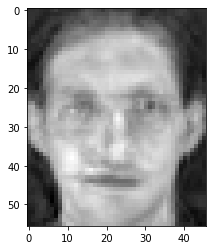

k: 49


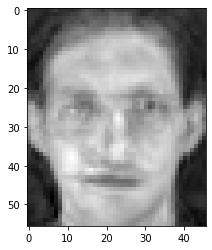

k: 50


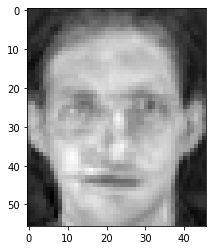

k: 51


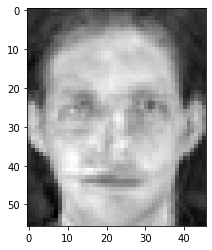

k: 52


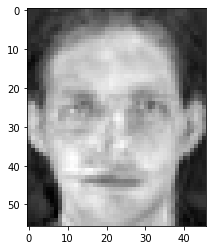

k: 53


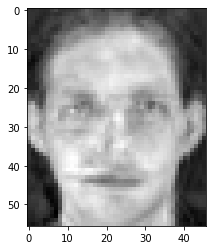

k: 54


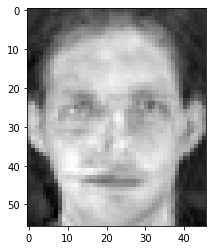

k: 55


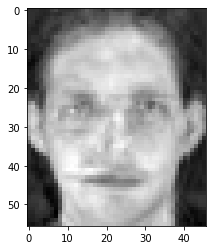

k: 56


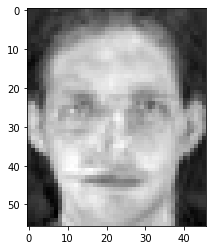

k: 57


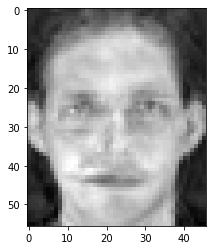

k: 58


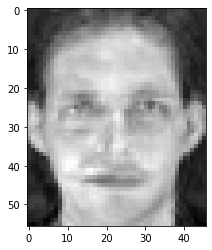

k: 59


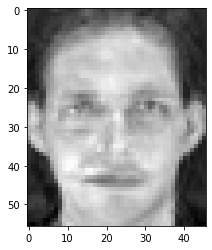

k: 60


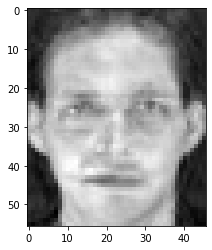

k: 61


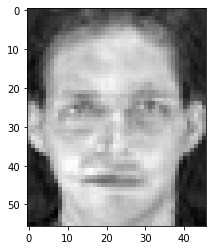

k: 62


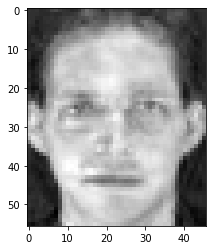

k: 63


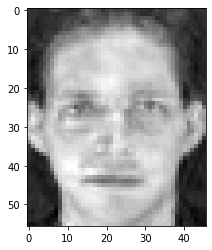

k: 64


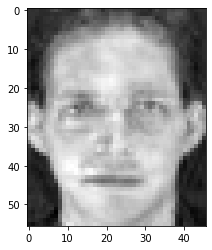

k: 65


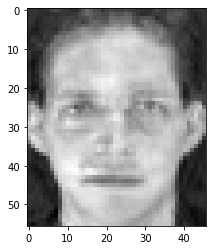

k: 66


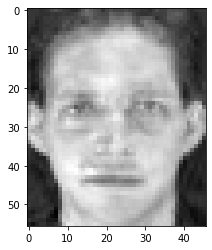

k: 67


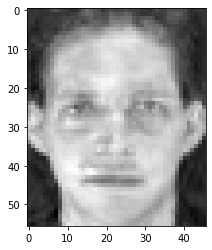

k: 68


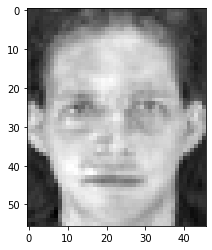

k: 69


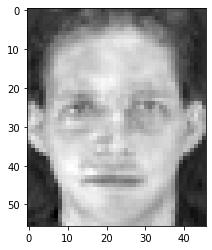

k: 70


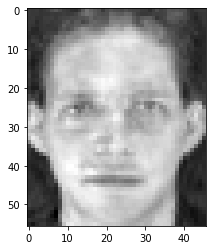

k: 71


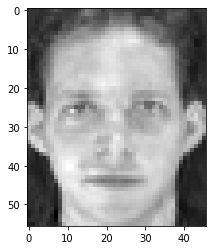

k: 72


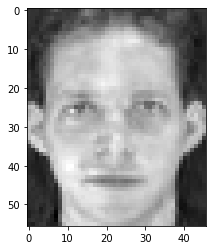

k: 73


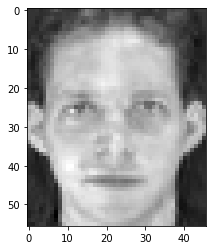

k: 74


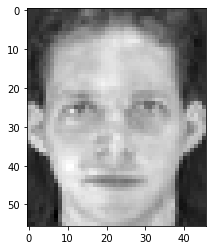

k: 75


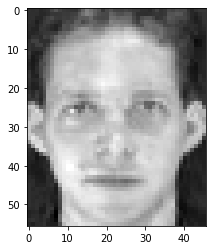

k: 76


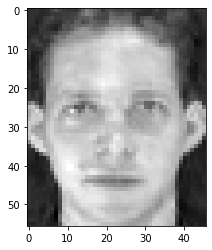

k: 77


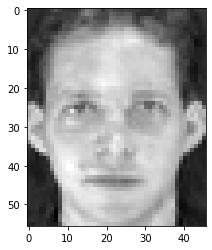

k: 78


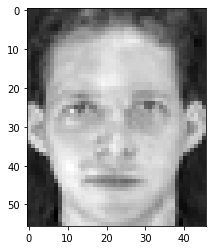

k: 79


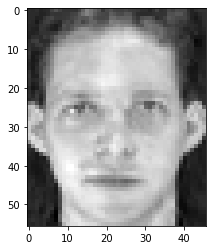

k: 80


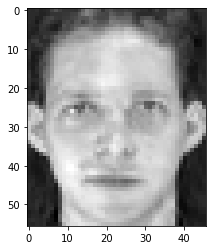

k: 81


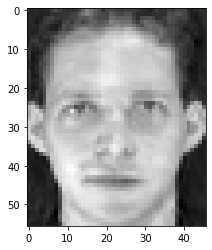

k: 82


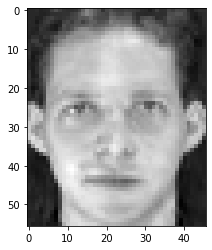

k: 83


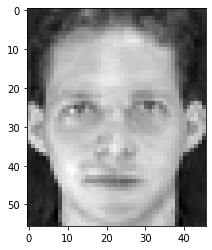

k: 84


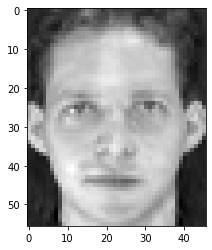

k: 85


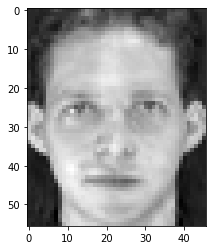

k: 86


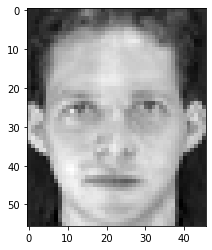

k: 87


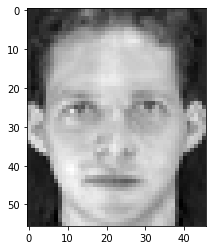

k: 88


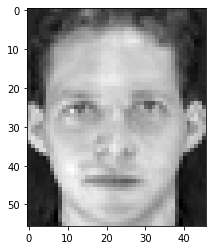

k: 89


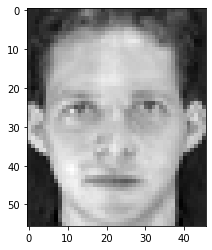

k: 90


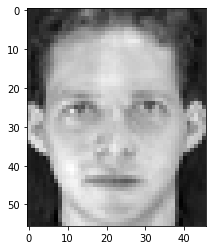

k: 91


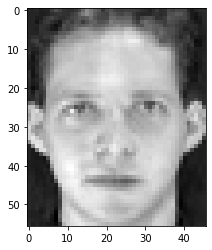

k: 92


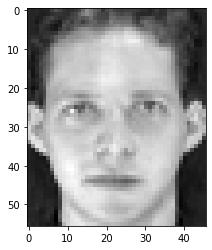

k: 93


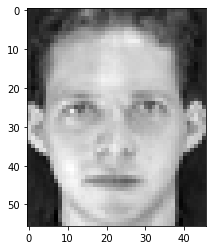

k: 94


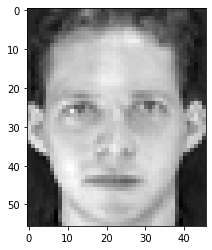

k: 95


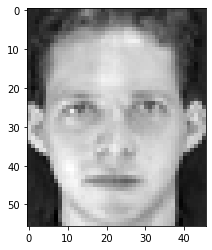

k: 96


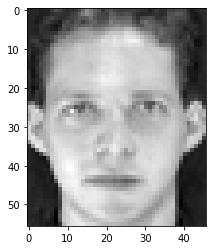

k: 97


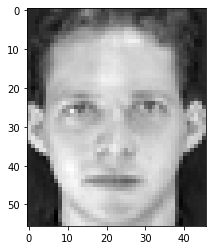

k: 98


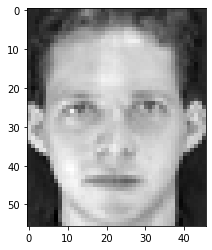

k: 99


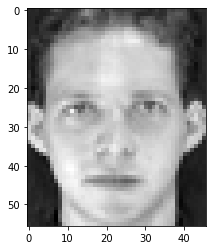

k: 100


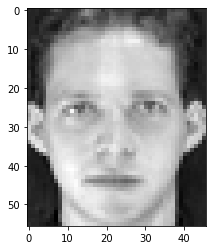

k: 101


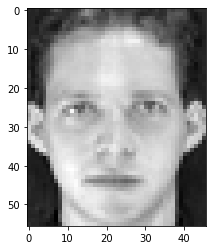

k: 102


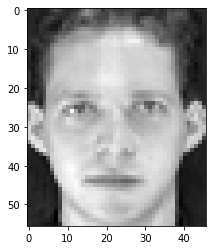

k: 103


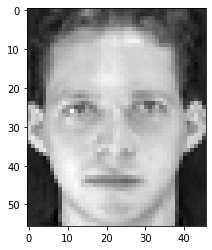

k: 104


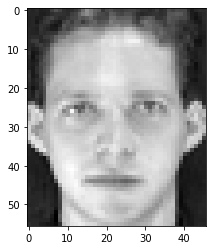

k: 105


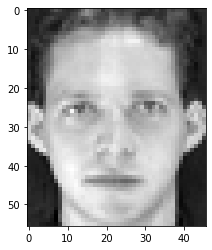

k: 106


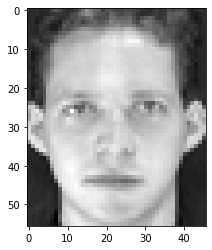

k: 107


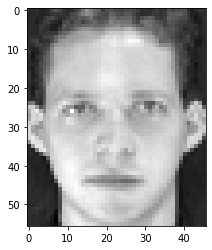

k: 108


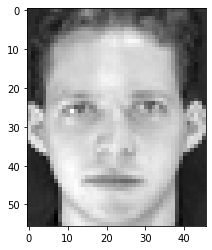

k: 109


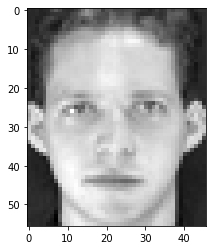

k: 110


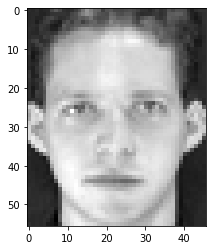

k: 111


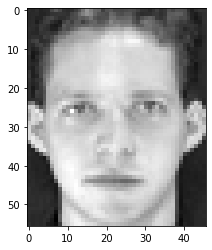

k: 112


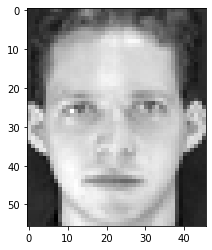

k: 113


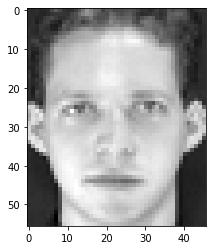

k: 114


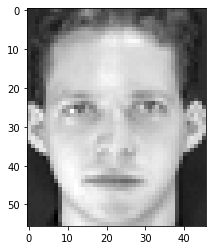

k: 115


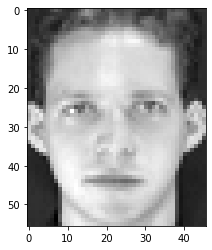

k: 116


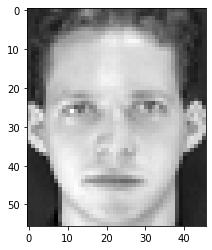

k: 117


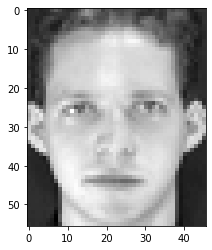

k: 118


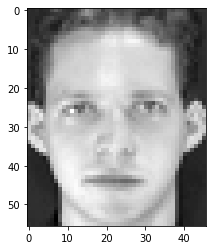

k: 119


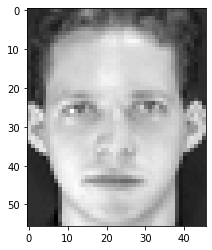

In [194]:
MSE_history = []
original_image_vec = T[0].reshape(-1)
for k in range(1, 120):
    print("k:",k)
    T_P_k = np.array([np.matmul(V.T[:k], x.reshape(x.shape[0], 1) - mean_x.reshape(mean_x.shape[0], 1)) for x in T_vecs])
    T_P_k = np.array([col_vec.reshape(-1) for col_vec in T_P_k])
    projection_vec = T_P_k[0]
    reconstructed_image_vec = mean_x + np.matmul(V.T[:k].T, projection_vec)
    plt.imshow(reconstructed_image_vec.reshape(56,46), cmap="gray")
    mse = MSE(original_image_vec, reconstructed_image_vec)
    MSE_history.append(mse)
    plt.show()

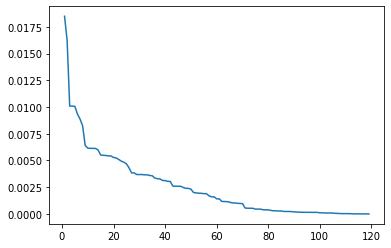

In [195]:
plt.plot(range(1, 120), MSE_history)
plt.show()

&emsp; **OT3.** Consider if we want to store 1,000,000 images of this type. How
much space do we need? If we would like to compress the database by using
the first 10 eigenvalues, how much space do we need? (Assume we keep the
projection values, the eigenfaces, and the meanface as 32bit floats)

&emsp; For each pixel size (32bit floats) is 4 Bytes. <br>
&emsp; Assume image size is 56x46 pixels, that means the image size is 56x46x4 = 10,304 Bytes $\approx$ 10 KB. <br>
&emsp; If we want to store 1,000,000 images, we need 10 GB space. <br>
&emsp; If we compress the database using 10 eigenvalues, <br>
&emsp;&emsp; - Each projection vector $(p \in \mathbb{R}^{10})$ size is 10x4 = 40 Bytes. All projection vectors size are 40x1e6  = 40 MB. <br>
&emsp;&emsp; - Each eigenface is an image, size is 10 KB. There are 10 eigenfaces. All eigenfaces size are 100 KB. <br>
&emsp;&emsp; - The meanface is an image, size is 10 KB. <br>
&emsp; Hence, we need 41 MB space.

### &emsp; Linear Discriminant Analysis (LDA)
&emsp; We learned in class that PCA serves well in terms of lowering the dimensionality of the data. However, it does not aim to maximize the classification accuracy. PCA actually aims to retain the most information in the lowest possible subspace (as shown from our reconstruction experiment). PCA is also an unsupervised algorithm. We did not use any class information when we compute for PCA. On the other hand, LDA takes the class labels as inputs and aim to find the projection that maximize the separability between the classes. <br>
&emsp; LDA is usually used in conjunction with PCA. We first project using PCA to a lower dimensionality then use LDA to project to a subspace that better separates the class. <br>
&emsp; Assuming everything is already in the PCA subspace, to find the LDA projections, we first need to find the between class scatter, $S_B$, and the within class scatter, $S_W$ . Between class scatter represents the spread between two classes. In class, for the two class example, it is defined as the distance between the means of class 1 and class 2 as shown below: <br>
$$S_B = (\vec{\mu_1} - \vec{\mu_2})(\vec{\mu_1} - \vec{\mu_2})^T$$
&emsp; In a multi-class setting, it is defined as the distance of the mean of each class with the global mean, $\mu$: <br>
$$S_B = \sum_{i=1}^N(\vec{\mu_i}-\vec{\mu})(\vec{\mu_i}-\vec{\mu})^T$$
&emsp; where $N_c$ is the number of classes. <br>
&emsp; $S_W$ represents the scatter within each class. For a class $i$, we can compute the scatter of the class by <br>
$$S_{W_i} = \sum_{j=1}^{N_i}(\vec{x_j}-\vec{\mu_i})(\vec{x_j}-\vec{\mu_i})^T$$
&emsp; where $N_i$ is the number of data in class $i$, $\vec{x_j}$ is the jth data sample from class $i$ (in the PCA subspace). <br>
&emsp; The total within class scatter, $S_W$, can then be computed by <br>
$$S_W = \sum_{i=1}^{N_c}\sum_{j=1}^{N_i}(\vec{x_j}-\vec{\mu_i})(\vec{x_j}-\vec{\mu_i})^T$$
&emsp; To find the LDA projection, we want to find a projection, $\vec{w}$, that maximizes $S_B$, but minimizes $S_W$. To do so, we maximize the ratio (the Fisher criterion): <br>
$$\frac{\vec{w}^TS_B\vec{w}}{\vec{w}^TS_W\vec{w}}$$
&emsp; After some calculus, the solution to this maximization is in the form: <br>
$$S_B\vec{w} = \lambda S_W\vec{w}$$
&emsp; If we assume, SW is invertible. This becomes <br>
$$S_W^{-1}S_B\vec{w} = \lambda\vec{w}$$
&emsp; In other words, the LDA projections are the eigenvectors of $S_W^{-1}S_B$

&emsp; **T21.** In order to assure that $S_W$ is invertible we need to make sure that $S_W$ is full rank. How many PCA dimensions do we need to keep in order for $S_W$ to be full rank? (Hint: How many dimensions does $S_W$ have? In order to be of full rank, you need to have the same number of linearly independent factors)


In [196]:
T_vecs.shape

(120, 2576)

&emsp; From train set, we have 3 faces of 40 people (C). <br>
&emsp; Each image has 2576 dimensions (L). <br>
&emsp; We have 120 images (N). <br>
&emsp; To make sure that $S_w$ is full rank, there are N-C = 80 dimensions we need to keep. <br>
&emsp; For $S_B$, it has C-1 = 39 ranks.

In [197]:
D_vecs.shape

(280, 2576)

&emsp; **T22.** Using the answer to the previous question, project the original input to the PCA subspace. Find the LDA projections. To find the inverse, use
**numpy.linalg.inv**. Is $S_W^{-1}S_B$ symmetric? Can we still use **numpy.linalg.eigh**? How many non-zero eigenvalues are there?

In [198]:
# Find PCA subspace
k = 80
T_PCA = np.array([np.matmul(V.T[:k], x.reshape(x.shape[0], 1) - mean_x.reshape(mean_x.shape[0], 1)) for x in T_vecs])
print(T_PCA.shape)
D_PCA = np.array([np.matmul(V.T[:k], x.reshape(x.shape[0], 1) - mean_x.reshape(mean_x.shape[0], 1)) for x in D_vecs])
print(D_PCA.shape)

(120, 80, 1)
(280, 80, 1)


In [199]:
# Find mean of each person in train set
mean_vecs = []
for i in range(0, T_PCA.shape[0], 3):
    mean_vecs.append(((T_PCA[i]+T_PCA[i+1]+T_PCA[i+2])/3))
mean_vecs = np.array(mean_vecs)
mean_vecs.shape

(40, 80, 1)

In [200]:
# Find S_W
N_c = 40
N_i = 3
S_W = np.zeros((80, 80))
for i in range(N_c):
    for j in range(N_i):
        x_j = T_PCA[i*3+j]
        x_j = x_j.reshape((x_j.shape[0], 1))
        mu_i = mean_vecs[i]
        diff = x_j - mu_i
        S_W += np.matmul(diff, diff.T)
S_W.shape

(80, 80)

In [201]:
# Find global mean
T_PCA_row = np.array([col_vec.reshape(-1) for col_vec in T_PCA])
glob_mean = np.array([dim.mean() for dim in T_PCA_row.T])
glob_mean.shape

(80,)

In [202]:
glob_mean

array([-1.18423789e-16, -1.92438658e-16,  5.92118946e-17, -4.44089210e-17,
        3.25665421e-16,  8.88178420e-17,  0.00000000e+00, -2.29446092e-16,
        7.40148683e-18, -8.88178420e-17, -6.66133815e-17,  1.92438658e-16,
       -1.92438658e-16, -2.22044605e-17,  3.70074342e-17,  2.96059473e-17,
       -1.25825276e-16,  6.66133815e-17, -4.07081776e-17,  8.88178420e-17,
       -1.25825276e-16, -9.62193288e-17,  1.03620816e-16,  8.14163551e-17,
       -9.62193288e-17,  1.48029737e-17, -3.70074342e-18, -1.09171931e-16,
       -3.88578059e-17, -3.70074342e-17,  1.33226763e-16,  1.85037171e-17,
       -2.59052039e-17, -1.48029737e-17,  5.36607795e-17, -9.62193288e-17,
        2.96059473e-17,  8.51170986e-17,  3.70074342e-17, -7.40148683e-18,
       -3.70074342e-18,  1.11022302e-16, -1.85037171e-17,  7.40148683e-18,
        2.12792746e-17, -8.14163551e-17, -3.70074342e-17, -1.48029737e-17,
        9.25185854e-17, -9.06682137e-17, -4.81096644e-17, -1.11022302e-17,
        0.00000000e+00,  

In [203]:
# Find S_B
S_B = np.zeros((80, 80))
for i in range(N_c):
    mu_j = mean_vecs[i]
    diff = mu_j - glob_mean
    S_B += np.matmul(diff, diff.T)
S_B.shape

(80, 80)

In [204]:
# Find inv(S_W)S_B
invS_W__S_B = np.matmul(np.linalg.inv(S_W), S_B)
invS_W__S_B.shape

(80, 80)

In [205]:
is_symmetric(invS_W__S_B)

False

&emsp; Because $S_W^{-1}S_B$ is not symmetric, we cannot use numpy.linalg.eigh to find the eigenvectors and eigenvalues. <br>
&emsp; We use numpy.linalg.eig instead.

In [206]:
LDA_ei_vals, LDA_proj = np.linalg.eig(invS_W__S_B)

In [207]:
LDA_ei_vals = LDA_ei_vals.real
LDA_proj = LDA_proj.real

In [208]:
sort_pos = np.argsort(LDA_ei_vals)
sort_pos

array([39, 40, 45, 51, 55, 54, 56, 57, 64, 53, 52, 63, 62, 70, 71, 68, 67,
       79, 78, 77, 42, 41, 58, 59, 75, 76, 72, 73, 74, 69, 65, 66, 61, 60,
       50, 49, 48, 47, 46, 44, 43, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29,
       28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 13, 14, 12,
       11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0], dtype=int64)

In [209]:
LDA_ei_vals = LDA_ei_vals[sort_pos][::-1]
LDA_proj = LDA_proj.T[sort_pos][::-1].T

In [210]:
LDA_ei_vals = LDA_ei_vals[:39]
LDA_proj = LDA_proj.T[:39].T

In [211]:
S_B_rank = (LDA_ei_vals > 1e-6).sum()
S_B_rank

39

&emsp; **T23.** Plot the first 10 LDA eigenvectors as images (the 10 best projections). Note that in this setup, you need to convert back to the original image space by using the PCA projection. The LDA eigenvectors can be considered as a linear combination of eigenfaces. Compare the LDA projections with the PCA
projections.

In [212]:
print(V.T[:80].shape)
print(LDA_proj.T.shape) # row vector

(80, 2576)
(39, 80)


In [213]:
LDA_ei_vecs = np.array([np.matmul(V.T[:80].T, proj_vec) for proj_vec in LDA_proj.T])
LDA_ei_vecs.shape

(39, 2576)

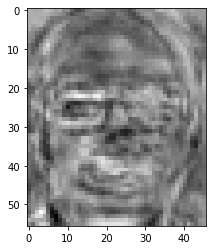

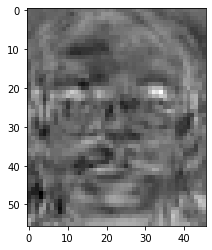

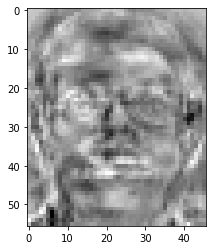

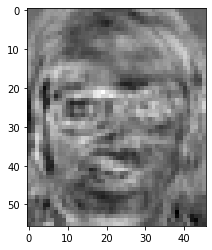

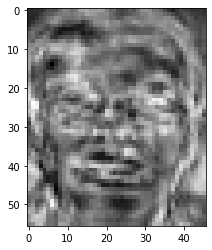

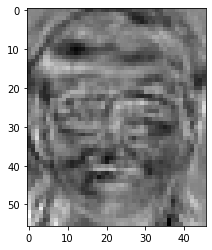

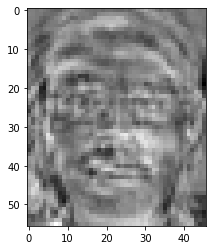

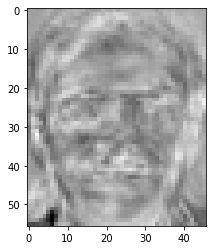

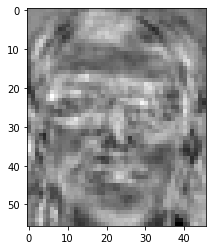

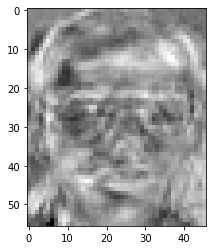

In [214]:
for vec in LDA_ei_vecs[:10]:
    plt.imshow(vec.reshape((56,46)),cmap="gray")
    plt.show()

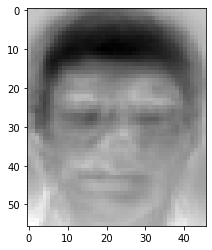

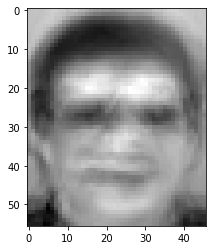

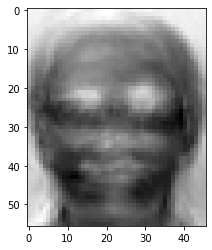

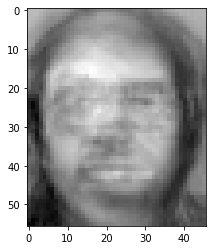

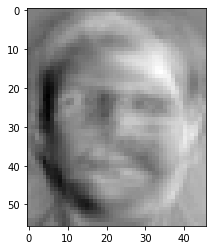

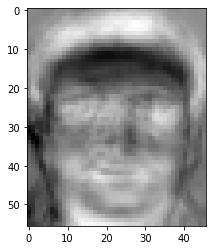

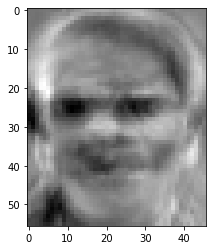

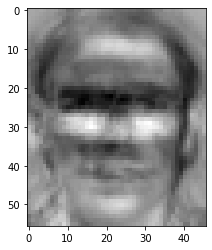

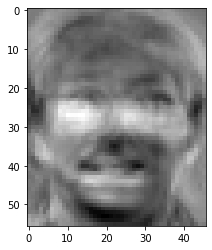

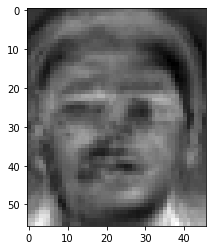

In [215]:
for vec in ei_vecs.T[:10]:
    img = vec.reshape(56, 46)
    plt.imshow(1-img,cmap="gray")
    plt.show()

&emsp; **T24.** The combined PCA+LDA projection procedure is called fisherface.
Calculate the fisherfaces projection of all images. Do the simple face verification experiment using fisherfaces. What is the EER and recall rate at 0.1% FAR?

In [216]:
# Find PCA subspace
k = 80
T_PCA = np.array([np.matmul(V.T[:k], x.reshape(x.shape[0], 1) - mean_x.reshape(mean_x.shape[0], 1)) for x in T_vecs])
print(T_PCA.shape)
D_PCA = np.array([np.matmul(V.T[:k], x.reshape(x.shape[0], 1) - mean_x.reshape(mean_x.shape[0], 1)) for x in D_vecs])
print(D_PCA.shape)
print(LDA_proj.shape)

(120, 80, 1)
(280, 80, 1)
(80, 39)


In [217]:
T_Fisher = np.array([np.matmul(LDA_proj.T, PCA_proj.reshape(-1)).reshape(-1) for PCA_proj in T_PCA])
print(T_Fisher.shape)
D_Fisher = np.array([np.matmul(LDA_proj.T, PCA_proj.reshape(-1)).reshape(-1) for PCA_proj in D_PCA])
print(D_Fisher.shape)

(120, 39)
(280, 39)


In [218]:
A_Fisher = np.zeros((T_Fisher.shape[0], D_Fisher.shape[0]))
for i in range(T_Fisher.shape[0]):
    for j in range(D_Fisher.shape[0]):
        A_Fisher[i,j] = Euclidian_distance(T_Fisher[i], D_Fisher[j])
print(A_Fisher)

[[4.35932423 2.73203219 3.92632562 ... 3.7024614  3.70215463 3.83067504]
 [4.25148754 2.47657858 3.90501217 ... 3.79470804 3.65591104 3.75020625]
 [4.22848265 2.55726273 3.90176105 ... 3.85137016 3.65822479 3.78197602]
 ...
 [4.95661158 4.32195298 5.05005782 ... 2.48463267 4.09727098 3.52418937]
 [4.67146998 4.0718102  4.65563983 ... 2.11937721 3.6815643  3.37921484]
 [4.54143398 4.20351441 4.74853148 ... 2.7271546  3.98805214 3.9907245 ]]


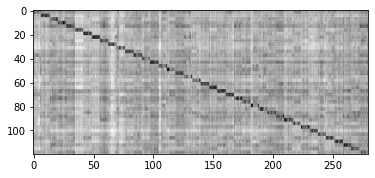

In [219]:
plt.imshow(A_Fisher, cmap="gray")
plt.show()

In [220]:
verify(A_Fisher, t=10)

(1.0, 1.0)

In [221]:
print(A_Fisher.min(), A_Fisher.max())

0.5118006405969856 6.439506441331767


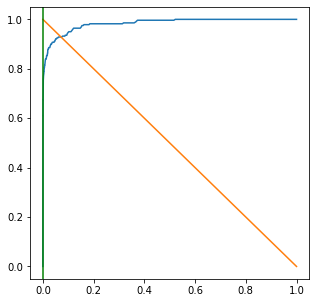

recall at 0.1% FAR: 0.42857142857142855 9.157509157509158e-05
EER: 0.9285714285714286 0.07115384615384615


In [234]:
(TPRs, FARs) = plot_RoC_from_A(A_Fisher, 0, 7, 1000, EER=True, FA=0.1/100)
for idx, FA in enumerate(FARs):
    if np.abs(FA-0.1/100) < 1e-3:
        TP_target = TPRs[idx]
        FA_target = FARs[idx]
        break
print("recall at 0.1% FAR:", TP_target, FA_target)
for idx, FA in enumerate(FARs):
    if np.abs(FA + TPRs[idx] - 1) < 1e-3:
        TP_target = TPRs[idx]
        FA_target = FARs[idx]
        break
print("EER:", TP_target, FA_target)

&emsp; **T25.** Plot the RoC of all three experiments (No projection, PCA, and
Fisher) on the same axes. Compare and contrast the three results. Submit your
writeup and code on MyCourseVille.

In [223]:
(TPRs_original, FARs_original) = plot_RoC_from_A(A,0,18,1000, EER=True, plot=False)

In [224]:
(TPRs_PCA, FARs_PCA) = plot_RoC_from_A(A_P_ks[10], 0, 18, 1000, EER=True, plot=False)

In [225]:
(TPRs_Fisher, FARs_Fisher) = plot_RoC_from_A(A_Fisher, 1, 7, 1000, EER=True, plot=False)

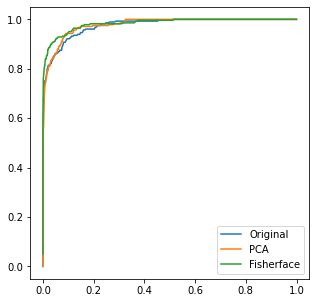

In [226]:
plt.figure(figsize=(5, 5))
plt.plot(FARs_original, TPRs_original)
plt.plot(FARs_PCA, TPRs_PCA)
plt.plot(FARs_Fisher, TPRs_Fisher)
plt.legend(["Original","PCA","Fisherface"])
plt.show()

&emsp; **OT4.** Plot the first two LDA dimensions of the test images from different people (6 people 7 images each). Use a different color for each person. Observe the clustering of between each person. Repeat the same steps for the PCA projections. Does it come out as expected?

In [227]:
D_Fisher_x = D_Fisher[:,0]
D_Fisher_y = D_Fisher[:,1]

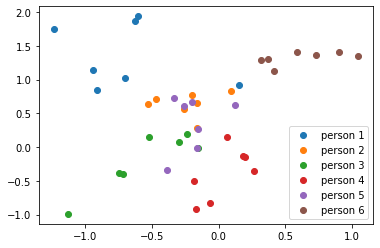

In [228]:
for i in range(6):
    plt.scatter(D_Fisher_x[i*7:i*7+7], D_Fisher_y[i*7:i*7+7])
plt.legend(["person 1","person 2","person 3","person 4","person 5","person 6"])
plt.show()

In [229]:
D_PCA_x = D_PCA[:,0]
D_PCA_y = D_PCA[:,1]

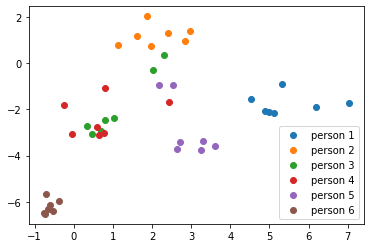

In [230]:
for i in range(6):
    plt.scatter(D_PCA_x[i*7:i*7+7], D_PCA_y[i*7:i*7+7])
plt.legend(["person 1","person 2","person 3","person 4","person 5","person 6"])
plt.show()

&emsp; From 2 scatters (Fisherface and PCA), it come out as we expected.